### Installing MDAnalysis and other modules used in this code

only testing for windows right now

pip install --upgrade MDAnalysis

pip install --upgrade MDAnalysis[analysis]

pip install --upgrade MDAnalysisTests

conda install -c conda-forge nodejs

jupyter labextension install @jupyter-widgets/jupyterlab-manager

Version History: 
06/10/2022 - Vincent La - original script
07/22/2022 - Eugene Ragasa - modified script to be more efficient when reused
08/03/2022 - Sean Kim - modified script to be more efficient when reused
Automated plotting, generalized reading files in directories, debugged
                 

adapted from https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsd.html

In [3]:
# Importing modules used for file management
import os 
import sys

# Importing modules used for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# the next line is necessary to display plots in Jupyter
%matplotlib inline

# Create file path for battery md module
# Battery md from Eugene Ragasa and Vincent La
battery_md_path = "/Users/kims3/Documents/projects/2CEE_Project/repo/battery_md-main/src/"
sys.path.append(battery_md_path)

# Importing premade classes and methods to analyze NVT data
# MDAnalysis is a public library
import MDAnalysis as mda
from MDAnalysis.analysis import rms, msd


In [4]:
def check_if_project_path_exists(project_path):
    project_path_exists = os.path.isdir(project_path)
    print(f"project_path:{project_path}")
    print(f"project_path_exists:{project_path_exists}")
    return os.path.isdir(project_path_exists)

def get_mixture_name(mixture, timesteps):
    mixture_ratios = [v for v in mixture['solvent_composition_by_volume'].values()]
    str_mixture_ratios = ":".join([str(k) for k in mixture_ratios])
    mixture_name = "_".join([timesteps, str_mixture_ratios])
    return mixture_name

def get_sim_name(mixture, T, timesteps):
    mixture_ratios = [v for v in mixture['solvent_composition_by_volume'].values()]
    str_mixture_ratios = "_".join([str(k) for k in mixture_ratios])
    molec_names = [k for k in mixture['solvent_composition_by_volume'].keys()]
    str_molec_names = "_".join([str(k) for k in molec_names])
    temp = str(T) + "K"
    fileName = "_".join([timesteps, mixture.get('solute_symbol'), str_mixture_ratios, str_molec_names, "nvt", temp])
    return fileName
    

In [5]:
def calculate_rmsd(trajectory_path="system.lammpstrj",
                   topology_path="system.start.data",
                   atom_symbols=["Li", "P"]):
    
    FS2PS = 1/1000 # femtoseconds to picoseconds

    timestep_in_fs = 1
    timesteps_between_dumps = 100

    atom_style = "id resid type x y z ix iy iz"

    dt = timestep_in_fs * timesteps_between_dumps * FS2PS

    u = mda.Universe(
        topology_path,  
        trajectory_path,
        topology_format = 'DATA', 
        format = 'LAMMPSDUMP', 
        atom_style = atom_style,
        dt = dt
    )
    

    # should replace this with something a little more robust
    atomic_masses = {'Li':6.941, 'P':30.9738}
    
    rmsd = {}
    for s, amu in atomic_masses.items():
        atom_type = u.atoms.groupby('masses')[atomic_masses[s]][0].type
        rmsd[s] = rms.RMSD(u, select=f"type {atom_type}", dt=dt)
        rmsd[s].run()
        
    return rmsd



def calculate_diffusion_coefficient(time:float,
                                    rmsd:float,
                                    degrees_of_freedom=3,
                                    unitsconversion_time2seconds=1e-15,
                                    unitsconversion_length2meters=1e-10):
    # diffusion equation:
    # <x^2> = 2 * d * D  * t 
    
    # fit -> rmsd_sq = mx
    model = LinearRegression(fit_intercept=False)
    model.fit(time, rmsd**2)

    m = model.coef_[0][0]

    # if we fit, rmsd^2 = m * t, then
 
    diffusion_coefficient = m / (2 * degrees_of_freedom)

    # diffusion coefficent is probably coming in as
    # time in ps
    # rmsd in Angs
    # -> units of D: Angs^2 / ps
    diffusion_coefficient *= unitsconversion_length2meters**2
    diffusion_coefficient /= unitsconversion_time2seconds

    return diffusion_coefficient



def calculate_ionic_conductivity(diffusion_constant:float,    
                           temperature:float,
                           ionic_concentration=1.)->float:
    
    """ Calculate diffusivity from Nerst Equation
    
    Parameters:
    diffusion_constant(float): diffuion constant (in SI)
    ionic_concentration(float): ionic concentration (in mol/L)
    temperature(float): temperature cosntant (in Kelvin)

    Returns:
    (float) conductiviy
    """

    # calculate conductivity
    boltzmanns_constant = 1.380649e-23 # m^2 kg / s^2 / K
    elementary_charge   = 1.602177e-19 # Columbs 
    avogradros_number = 6.022141e+23 # 1/mol
    # Boltzmann constant

    D = diffusion_constant
    # Nernst equation for conductivity, kappa = D * c * e**2 * N_A / (k_B * T)
    kappa = diffusion_constant * ionic_concentration * elementary_charge**2 * avogradros_number \
            / (boltzmanns_constant * temperature)
            
    return kappa

In [12]:
# Function to create line-graph of columns of the data
def line_plots(mixtures, fig_num, x, y, title, xlabel='', ylabel=''):
    
    
    fig_name = "Fig" + str(fig_num)
    figure = plt.figure(fig_name)
    
    for mixture in mixtures:
        df = data[data['mixture_name'] == mixture]
        plt.plot(df[x], df[y], label = mixture[5:])
        
    # Customize/format plots
    plt.title(title)
    plt.xlim(df[x].min(), df[x].max())
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(loc="upper left")
    plt.show
    
    plt.savefig(".".join([plot_path, title, "png"]))

In [7]:
project_path = "000allMixtures"
project_path_exists = os.path.isdir(project_path)
print(f"project_path={project_path}")
print(f"project_path_exists={project_path_exists}")
missing_files_path = os.path.join(project_path, "missing_files.txt")

# list of temps I held the simulation at
temperatures = [230, 240, 250, 260, 270, 280, 290, 300]

# temperature mixture
electrolyte_mixtures = [
    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'CEE': 100, 'MPN': 0}},
    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'CEE': 66, 'MPN': 33}},
    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'CEE': 33, 'MPN': 66}},
    {'solute_n_moles': 1.0, 'solute_symbol': 'LiPF6', 'solvent_composition_by_volume': {'CEE': 0, 'MPN': 100}}
]

atom_symbols = ["Li", "P"]
solvent_symbols = ['2CEE', '3MPN']


project_path=000allMixtures
project_path_exists=True


In [47]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [54]:
results = []

# For each mixture combination
for idx_m, m in enumerate(electrolyte_mixtures):
    mixture_name = get_mixture_name(m, "100K")
    
    #Checking for mixture names and index
    #print(f"idx_m={idx_m}")
    #print(f"m={m}")
    #print(f"mixture_name={mixture_name}")
    
    # For each temperature
    for idx_T, T in enumerate(temperatures):
        
        #Checking for temperatures and index
        #print(f"idx_T={idx_T}")
        #print(f"T={T}")
    
        # Initialize dictionary for results
        result = {}
        # Add mixture names
        result["mixture_name"] = mixture_name
        # Add temperatures
        result["temperature"] = T
        
        # Find file path for production.lammpstrj for each temperature and mixture
        job_name = os.path.join(project_path, get_sim_name(m, T, "100K"))
        trajectory_path = os.path.join(job_name, 'system.production.lammpstrj')
        topology_path = os.path.join(job_name, 'system.data')
        
        print(result)
        
        ionic_concentration = 1.0
        degrees_of_freedom = 3
        
        # check if file exists
        # check types of each variable
        
#         print(f"\ntrajectory_path={trajectory_path}:{os.path.isfile(trajectory_path)}")
#         print(trajectory_path, type(trajectory_path))
        
#         print(f"\ntopology_path={topology_path}:{os.path.isfile(topology_path)}")
#         print(topology_path, type(topology_path))
        
#         print(f"\natom_symbols={atom_symbols}")
#         print(atom_symbols, type(atom_symbols))
        
        
        
        #o_rmsd is a MDAnalaysis.analysis.rms.RMSD object
        result["o_rmsd"] = calculate_rmsd(trajectory_path,
                                           topology_path,
                                           atom_symbols)

        for s in atom_symbols:

            # get time-series for time and rmsd arrays
            # cast into column arrays for
            time = np.array(result['o_rmsd'][s].results['rmsd'][:,0], copy=True).reshape(-1,1)
            rmsd = np.array(result['o_rmsd'][s].results['rmsd'][:,2], copy=True).reshape(-1,1)

            # calculate diffusion
            diffusion_coefficient = calculate_diffusion_coefficient(
                    time=time,
                    rmsd=rmsd,
                    degrees_of_freedom=3,
                    unitsconversion_time2seconds=1e-12,
                    unitsconversion_length2meters=1e-9
            )

            #calculate ionic conductivity
            ionic_conductivity =  calculate_ionic_conductivity(
                    diffusion_constant=diffusion_coefficient,
                    temperature=T,
                    ionic_concentration=ionic_concentration
            )

            result['{}.D'.format(s)] = diffusion_coefficient
            result['{}.kappa'.format(s)] = ionic_conductivity


        results.append(result)


{'mixture_name': '100K_100:0', 'temperature': 230}
{'mixture_name': '100K_100:0', 'temperature': 240}
{'mixture_name': '100K_100:0', 'temperature': 250}
{'mixture_name': '100K_100:0', 'temperature': 260}
{'mixture_name': '100K_100:0', 'temperature': 270}
{'mixture_name': '100K_100:0', 'temperature': 280}
{'mixture_name': '100K_100:0', 'temperature': 290}
{'mixture_name': '100K_100:0', 'temperature': 300}
{'mixture_name': '100K_66:33', 'temperature': 230}
{'mixture_name': '100K_66:33', 'temperature': 240}
{'mixture_name': '100K_66:33', 'temperature': 250}
{'mixture_name': '100K_66:33', 'temperature': 260}
{'mixture_name': '100K_66:33', 'temperature': 270}
{'mixture_name': '100K_66:33', 'temperature': 280}
{'mixture_name': '100K_66:33', 'temperature': 290}
{'mixture_name': '100K_66:33', 'temperature': 300}
{'mixture_name': '100K_33:66', 'temperature': 230}
{'mixture_name': '100K_33:66', 'temperature': 240}
{'mixture_name': '100K_33:66', 'temperature': 250}
{'mixture_name': '100K_33:66', 

In [15]:
# # Read this data as a pandas dataframe
 data = pd.DataFrame(results)
# data

In [16]:
# write results as .csv
results_path = '{}_{}.csv'.format('LiPF6', 'CEE_MPN')
data.to_csv(os.path.join(project_path, results_path))

In [10]:
# Since above code takes too long
# Read generated csv 
data = pd.read_csv (os.path.join(project_path, results_path))

# Organize dataframe to remove o_rmsd and index
data_org = data.drop(columns = ["o_rmsd", "Unnamed: 0"])
data_org

,mixture_name,temperature,Li.D,Li.kappa,P.D,P.kappa
0,100K_100:0,230,1.711657e-08,0.083325,4.156705e-09,0.020235
1,100K_100:0,240,1.318724e-08,0.061522,6.614542e-09,0.030859
2,100K_100:0,250,1.315744e-08,0.058928,6.561208e-09,0.029385
3,100K_100:0,260,1.702067e-08,0.073298,2.957023e-09,0.012734
4,100K_100:0,270,7.288148e-09,0.030223,6.591142e-09,0.027333
5,100K_100:0,280,1.230735e-08,0.049215,4.241345e-09,0.016960
6,100K_100:0,290,1.726413e-08,0.066655,2.391535e-08,0.092335
7,100K_100:0,300,1.369436e-08,0.051110,1.046642e-08,0.039063
8,100K_66:33,230,1.694222e-08,0.082477,1.966479e-08,0.095730
9,100K_66:33,240,1.353097e-08,0.063126,2.643908e-08,0.123346


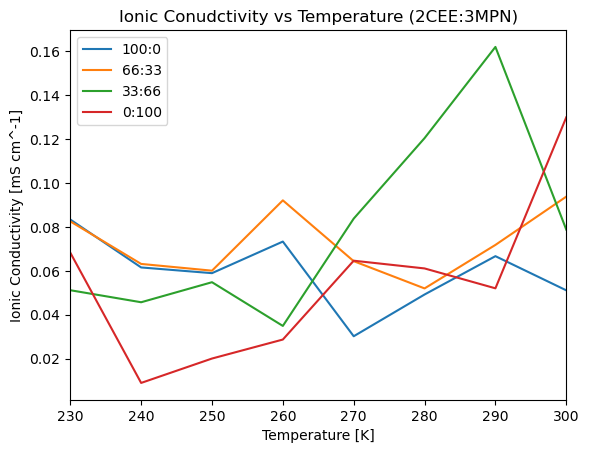

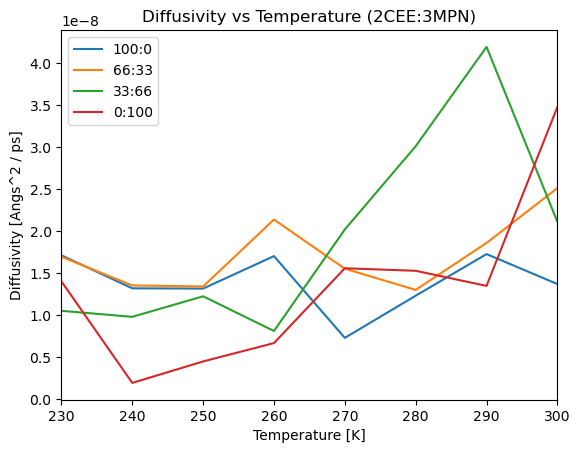

In [14]:
#plotting
from matplotlib import style
style.use('default')

plot_path = os.path.join(project_path, 'plots')
mixtures = data.mixture_name.unique() 


line_plots(mixtures, 1, 'temperature', 'Li.kappa', title = 'Ionic Conudctivity vs Temperature (2CEE:3MPN)', 
           xlabel='Temperature [K]', ylabel='Ionic Conductivity [mS cm^-1]')

line_plots(mixtures, 2, 'temperature', 'Li.D', title = 'Diffusivity vs Temperature (2CEE:3MPN)', 
           xlabel='Temperature [K]', ylabel='Diffusivity [Angs^2 / ps]')